# EMI Music Data Science Hackaton

##### Description
“Soulful” ... “Catchy” ... “Cool" ... "Cheesy" ... "Edgy”

How do people connect to and describe the music they have just heard?

EMI Insight performs extensive market research about their artists by interviewing thousands of people around the world. This research has produced EMI One Million Interview Dataset; one of the largest music preference datasets in the world today, that connects data about people--who they are, where they live, how they engage with music in their daily lives-- with their opinions about EMI’s artists.
This Data Science London hackathon will focus on one key subset of this data: understanding what it is about people and artists that predicts how much people are going to like a particular track. We have taken a sample of the data from the United Kingdom that provides a granular mixture of profile, word-association, and rating data.

The goal of this weekend hackathon is to design an algorithm that combines users’ (a) demographics, (b) artist and track ratings, (c) answers to questions about their preferences for music, and (d) words that they use to describe EMI artists in order to predict how much they like tracks they have just heard.

##### Data description
1. You are provided with five files:
    * Train/test. This csv file contains data that relate to how people rate EMI artists, during the market research interviews, right after hearing a sample of an artist’s song. The 6 columns are:
    * Artist. An anonymised identifier for the EMI artist.
    * Track. An anonymised identifier for the artist’s track.
    * User. An anonymised identifier for the market research respondent, who will have just heard a sample from the track.
    * Rating. A number between X-100 which answers the question: How much do you like or dislike the music?  (Train only, you're predicting this for the test set)
    * Time. The time the market research was completed: It is the anonymised research date indicating which month the research was conducted in. It can help you understand which other artists/tracks were researched in the same wave. Note it is not in chronological order
2. Words. This csv file contains data that shows how people describe the EMI artists whose music they have just heard.
     * Artist. An anonymised identifier for the EMI artist.
     * User. An anonymised identifier for the market research respondent, who will have just heard one or more samples from the artist.
     * HEARD_OF. An entry which answers the question: Have you heard of and/or heard music by this artist?
    * OWN_ARTIST_MUSIC, which answers the question: Do you have this artist in your music collection?
    * LIKE_ARTIST. A numerical entry which answers the question: To what extent do you like or dislike listening this artist?
    * Finally, a list of words. There are 82 different words, ranging from “Soulful” to “Cheesy” and “Aggressive.” After listening to tracks from a particular artist, each respondent will have selected the words they think best describe the artist from a given set. The values in each column are therefore 1, if the respondent thinks that word describes the artist, 0 if the respondent does not think the word describes the artist, and empty if the word was not part of the current interview set.
3. UserKey and users: The final csv files gives data about the respondents themselves, including their attitude towards music. The columns include:
    * User. The anonymised user identifier
    * Gender. Male/female
    * Age. The respondent’s age, in years.
    * Working status. Whether they are working full-time/retired/etc.
    * Region. The region of the United Kingdom where they live.
    * MUSIC. The respondent’s view on the importance of music in his/her life.
    * LIST_OWN. An estimate for the number of daily hours spent listening to music they own or have chosen.
    * LIST_BACK. An estimate for the number of daily hours the respondent spends listening to background music/music they have not chosen.
    * Music habit questions. Each of these asks the respondent to rate, on a scale of X-100, whether they agree with the following:
        1. I enjoy actively searching for and discovering music that I have never heard before
        2. I find it easy to find new music
        3. I am constantly interested in and looking for more music
        4. I would like to buy new music but I don’t know what to buy
        5. I used to know where to find music
        6. I am not willing to pay for music
        7. I enjoy music primarily from going out to dance
        8. Music for me is all about nightlife and going out
        9. I am out of touch with new music
        10. My music collection is a source of pride
        11. Pop music is fun
        12. Pop music helps me to escape
        13. I want a multi media experience at my fingertips wherever I go
        14. I love technology
        15. People often ask my advice on music - what to listen to
        16. I would be willing to pay for the opportunity to buy new music pre-release
        17. I find seeing a new artist / band on TV a useful way of discovering new music
        18. I like to be at the cutting edge of new music
        19. I like to know about music before other people

##### Imports

In [60]:
import os
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

##### Dataframes

In [3]:
path = 'data/'

In [4]:
train_df = pd.read_csv(f'{path}train.csv', delimiter=',', encoding='ISO-8859-2')
train_df.head()


,Artist,Track,User,Rating,Time
0,40,179,47994,9,17
1,9,23,8575,58,7
2,46,168,45475,13,16
3,11,153,39508,42,15
4,14,32,11565,54,19


In [5]:
test_df = pd.read_csv(f'{path}test.csv', delimiter=',', encoding='ISO-8859-2')
test_df.head()


,Artist,Track,User,Time
0,1,6,3475,18
1,6,149,39210,15
2,40,177,47861,17
3,31,79,27413,11
4,26,66,23232,22


In [6]:
users_df = pd.read_csv(f'{path}users.csv', delimiter=',', encoding='ISO-8859-2')
users_df.head()

,RESPID,GENDER,AGE,WORKING,REGION,MUSIC,LIST_OWN,LIST_BACK,Q1,Q2,...,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19
0,36927,Female,60.0,Other,South,Music is important to me but not necessarily m...,1 hour,NaN,49.0,50.0,...,50.0,50.0,71.0,52.0,71.0,9.0,7.0,72.0,49.0,26.0
1,3566,Female,36.0,Full-time housewife / househusband,South,Music is important to me but not necessarily m...,1 hour,1 hour,55.0,55.0,...,12.0,65.0,65.0,80.0,79.0,51.0,31.0,68.0,54.0,33.0
2,20054,Female,52.0,Employed 30+ hours a week,Midlands,I like music but it does not feature heavily i...,1 hour,Less than an hour,11.0,50.0,...,50.0,94.0,51.0,74.0,66.0,27.0,46.0,73.0,8.0,31.0
3,41749,Female,40.0,Employed 8-29 hours per week,South,Music means a lot to me and is a passion of mine,2 hours,3 hours,81.0,80.0,...,76.0,74.0,64.0,73.0,85.0,61.0,77.0,76.0,78.0,88.0
4,23108,Female,16.0,Full-time student,North,Music means a lot to me and is a passion of mine,3 hours,6 hours,76.0,79.0,...,56.0,13.0,82.0,79.0,68.0,71.0,NaN,86.0,80.0,32.0


In [7]:
words_df = pd.read_csv(f"{path}words.csv", delimiter=',', encoding='ISO-8859-2')
words_df.head()

,Artist,User,HEARD_OF,OWN_ARTIST_MUSIC,LIKE_ARTIST,Uninspired,Sophisticated,Aggressive,Edgy,Sociable,...,Unoriginal,Dated,Iconic,Unapproachable,Classic,Playful,Arrogant,Warm,Soulful,Unnamed: 87
0,47,45969,Heard of,NaN,NaN,NaN,0.0,NaN,0,0.0,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0,0.0,NaN
1,35,29118,Never heard of,NaN,NaN,0.0,NaN,0.0,0,NaN,...,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0,NaN,NaN
2,14,31544,Heard of,NaN,NaN,0.0,NaN,0.0,0,NaN,...,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0,NaN,NaN
3,23,18085,Never heard of,NaN,NaN,NaN,NaN,0.0,0,NaN,...,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0,NaN,NaN
4,23,18084,Never heard of,NaN,NaN,NaN,NaN,0.0,0,NaN,...,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0,NaN,NaN


In [8]:
user_key_df = pd.read_csv(f'{path}UserKey.csv', engine='python', sep=";")
user_key_df.head()

,"RESPID,User id"
0,"GENDER,Male/Female"
1,"AGE,Age in years"
2,"WORKING,Working status"
3,"REGION,Region of the UK"
4,"MUSIC,Listening to music that you have chosen ..."


In [9]:
users_mean_benchmark_df = pd.read_csv(f'{path}users_mean_benchmark.csv', delimiter=';', encoding='ISO-8859-2')
users_mean_benchmark_df.head()

,3.775000000000000000e+01
0,46.000000
1,12.666667
2,30.000000
3,25.142857
4,36.166667


In [10]:
artists_mean_benchmark_df = pd.read_csv(f'{path}artists_mean_benchmark.csv', delimiter=';', encoding='ISO-8859-2')
artists_mean_benchmark_df.head()

,2.987554269175108601e+01
0,39.933135
1,33.106768
2,23.213052
3,42.530841
4,42.530841


In [11]:
tracks_mean_benchmark_df = pd.read_csv(f'{path}tracks_mean_benchmark.csv', delimiter=';', encoding='ISO-8859-2')
tracks_mean_benchmark_df.head()

,2.859152907394113541e+01
0,40.857420
1,32.813911
2,22.954789
3,40.060900
4,46.547465


In [12]:
global_mean_benchmark_df = pd.read_csv(f'{path}global_mean_benchmark.csv', delimiter=';', encoding='ISO-8859-2')
global_mean_benchmark_df.head()

,3.643539138269118638e+01
0,36.435391
1,36.435391
2,36.435391
3,36.435391
4,36.435391


In [13]:
users_df['Q1'].value_counts()

51.00     1734
49.00     1382
50.00     1371
52.00     1275
100.00    1236
          ... 
53.23        1
28.95        1
85.97        1
39.42        1
69.93        1
Name: Q1, Length: 217, dtype: int64

In [14]:
words_df.dtypes

Artist                int64
User                  int64
HEARD_OF             object
OWN_ARTIST_MUSIC     object
LIKE_ARTIST         float64
                     ...   
Playful             float64
Arrogant            float64
Warm                  int64
Soulful             float64
Unnamed: 87         float64
Length: 88, dtype: object

In [15]:
users_df['GENDER'].value_counts()

Female    24503
Male      24142
Name: GENDER, dtype: int64

In [50]:
users_df.head()

,RESPID,GENDER,AGE,WORKING,REGION,MUSIC,LIST_OWN,LIST_BACK,Q1,Q2,...,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19
0,36927,Female,60.0,Other,South,Music is important to me but not necessarily m...,1 hour,NaN,49.0,50.0,...,50.0,50.0,71.0,52.0,71.0,9.0,7.0,72.0,49.0,26.0
1,3566,Female,36.0,Full-time housewife / househusband,South,Music is important to me but not necessarily m...,1 hour,1 hour,55.0,55.0,...,12.0,65.0,65.0,80.0,79.0,51.0,31.0,68.0,54.0,33.0
2,20054,Female,52.0,Employed 30+ hours a week,Midlands,I like music but it does not feature heavily i...,1 hour,Less than an hour,11.0,50.0,...,50.0,94.0,51.0,74.0,66.0,27.0,46.0,73.0,8.0,31.0
3,41749,Female,40.0,Employed 8-29 hours per week,South,Music means a lot to me and is a passion of mine,2 hours,3 hours,81.0,80.0,...,76.0,74.0,64.0,73.0,85.0,61.0,77.0,76.0,78.0,88.0
4,23108,Female,16.0,Full-time student,North,Music means a lot to me and is a passion of mine,3 hours,6 hours,76.0,79.0,...,56.0,13.0,82.0,79.0,68.0,71.0,NaN,86.0,80.0,32.0


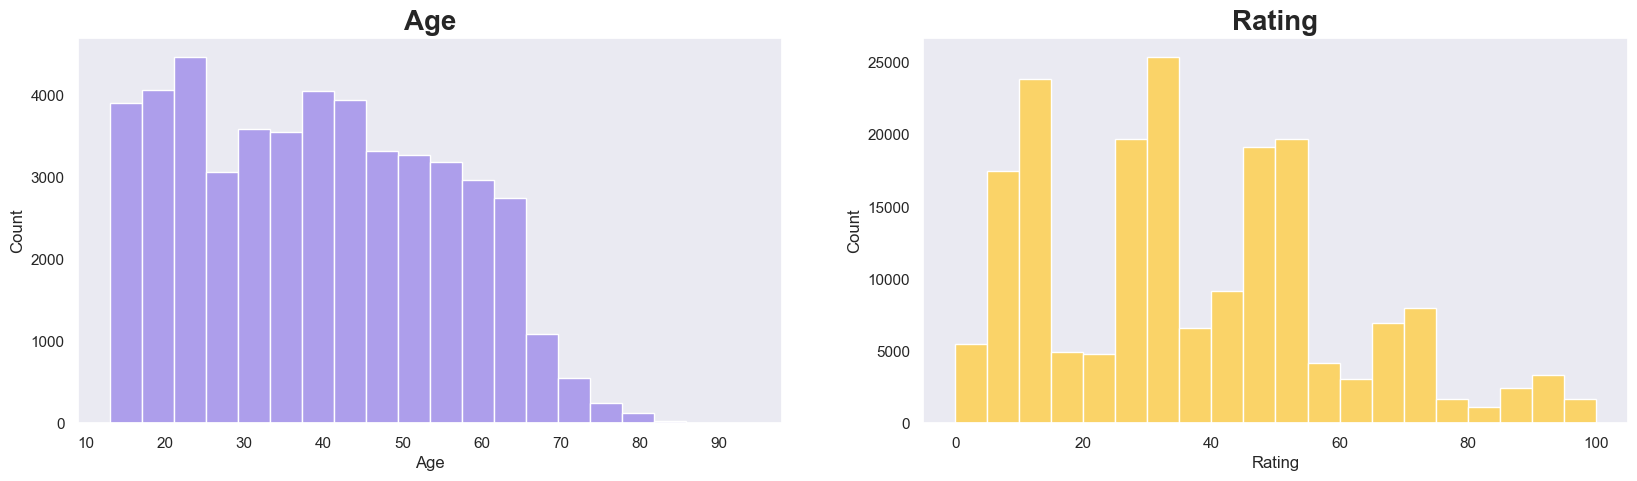

In [78]:
sns.set_theme(rc={'figure.figsize':(20,5)})
plt.subplot(1,2,1)
plt.title('Age', fontweight='bold', fontsize=20)
plt.hist(users_df['AGE'], bins=20, color='#AD9EEB')
plt.grid(False)
plt.xlabel('Age')
plt.ylabel('Count')

plt.subplot(1,2,2)
plt.title('Rating', fontweight='bold', fontsize=20)
plt.hist(train_df['Rating'], bins=20, color='#FAD368')
plt.grid(False)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()